In [1]:
################################################################################                                                                                                                                                              
################################################################################
#
# FILE: proximity.ipynb
#
# BY: Dmitry Sedov 
#
# CREATED: Tue Jan 21 2020
#
# DESC: Code to construct a CBG-observation dataset to plot a simple 
#       relationship between restaurant visits and proximity to 
#       consumers/establishments.
#
# COMMENT: 
#
################################################################################
################################################################################

In [2]:
############################# Libraries ########################################

import psycopg2
import sqlalchemy as db
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

################################################################################

In [3]:
############################### Options ########################################

sns.set_palette('tab10')

################################################################################

In [4]:
######################### Database connections #################################

# Connect to the database via SQLalchemy                                                                           
engine = db.create_engine('postgresql://{user}:{user_pass}@{host}/{dataname1}')                                                       
connection = engine.connect()                                                                                      

################################################################################

In [5]:
############################# SQL queries ######################################

# Create a table with CBGs' device count and CBSA affiliation
cbg_table_statement = """
SELECT
    CONCAT(g.statefips, g.countyfips, g.tractcode) AS ct,
    g.censusblockgroup AS cbg,
    g.cbsa,
    h.number_devices_residing
FROM
    geometry_cbg AS g
LEFT JOIN
    home_panel AS h
ON
    g.censusblockgroup = h.census_block_group;
"""

# Create a restaurants table with CBG affiliation and visits
restaurants_table_statement = """
WITH restaurants AS (
    SELECT
        p.sname_place_id,
        p.total_minutes_open,
        pa.raw_visit_counts,
        g.cbg,
        g.area_m2
    FROM
        pois AS p
    LEFT JOIN
        patterns AS pa
    ON  
        p.sname_place_id = pa.sname_place_id
    LEFT JOIN
        geometry_pois AS g
    ON  
        p.sname_place_id = g.sname_place_id
    WHERE 
        p.naics_code IN (722511, 722513)
) 
SELECT 
    cbg,
    COUNT(sname_place_id) AS rest_number,
    SUM(total_minutes_open) AS rest_minutes,
    SUM(raw_visit_counts) AS rest_visits,
    SUM(area_m2) AS rest_area
FROM
    restaurants
WHERE 
    raw_visit_counts IS NOT NULL
GROUP BY 
    cbg;
"""

# Create an establishments table with CBG affiliation and visits
establishments_table_statement = """
WITH establishments AS (
    SELECT
        p.sname_place_id,
        p.total_minutes_open,
        pa.raw_visit_counts,
        g.cbg,
        g.area_m2
    FROM
        pois AS p
    LEFT JOIN
        patterns AS pa
    ON  
        p.sname_place_id = pa.sname_place_id
    LEFT JOIN
        geometry_pois AS g
    ON  
        p.sname_place_id = g.sname_place_id
    WHERE 
        p.naics_code NOT IN (722511, 722513)
) 
SELECT 
    cbg,
    COUNT(sname_place_id) AS est_number,
    SUM(total_minutes_open) AS est_minutes,
    SUM(raw_visit_counts) AS est_visits,
    SUM(area_m2) AS est_area
FROM
    establishments
WHERE 
    raw_visit_counts IS NOT NULL
GROUP BY 
    cbg;
"""

################################################################################

In [6]:
##################### Read SQL queries into pandas #############################

cbg_table = pd.read_sql(cbg_table_statement, engine)
restaurants_table = pd.read_sql(restaurants_table_statement, engine)
establishments_table = pd.read_sql(establishments_table_statement, engine)

################################################################################

In [7]:
####################### Close database connections #############################

engine.dispose()

################################################################################

In [8]:
######################### Data preparation #####################################

# Merge datasets
data_cbg = pd.merge(cbg_table, restaurants_table, how = 'left', on = 'cbg')
data_cbg = pd.merge(data_cbg, establishments_table, how = 'left', on = 'cbg')

# Selecting data in CBSAs only
data_cbg = data_cbg.loc[data_cbg['cbsa'].notnull()].copy()

# Filling in missing data
values = {'number_devices_residing': 0, 
          'rest_number': 0, 
          'rest_visits': 0, 
          'est_number': 0,
          'est_visits': 0
         }
data_cbg.fillna(value = values,
               inplace = True)

# Fill in restaurant minutes to be 0 if no restaurants in cbg
rows = data_cbg['rest_number'] == 0
for col in ['rest_minutes', 'rest_area']:
    data_cbg.loc[rows, col] = 0
    
# Fill in establishment minutes to be 0 if no restaurants in cbg
rows = data_cbg['est_number'] == 0
for col in ['est_minutes', 'est_area']:
    data_cbg.loc[rows, col] = 0
    
# Average restaurant visits
data_cbg['rest_average_visits'] = data_cbg.rest_visits / data_cbg.rest_number

# Select only CBGs with restaurants
data_cbg = data_cbg.loc[data_cbg['rest_visits'] > 0].copy()

# Restaurants competition column 
data_cbg['rest_comp'] = pd.qcut(data_cbg['rest_number'],
                               3, 
                               labels = ['Low',  
                                         'Medium',
                                         'High'])

################################################################################

In [9]:
data_cbg

,ct,cbg,cbsa,number_devices_residing,rest_number,rest_minutes,rest_visits,rest_area,est_number,est_minutes,est_visits,est_area,rest_average_visits,rest_comp
10,02090001100,020900011001,21820,852.0,2.0,44310.0,378.0,17943.032315,16.0,9300.0,4578.0,68479.169048,189.000000,Low
12,02170000800,021700008002,11260,157.0,8.0,39300.0,1750.0,11629.403025,21.0,143340.0,2870.0,25998.745465,218.750000,High
17,02020001500,020200015002,11260,54.0,4.0,48540.0,519.0,3351.601039,5.0,47040.0,426.0,11395.203351,129.750000,Medium
24,02020001100,020200011001,11260,1020.0,20.0,199650.0,4241.0,24827.205054,64.0,534420.0,16125.0,109174.702815,212.050000,High
25,02090000700,020900007001,21820,155.0,4.0,55440.0,656.0,1278.449461,20.0,196410.0,1565.0,16039.807989,164.000000,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220237,56025001800,560250018001,16220,100.0,1.0,NaN,31.0,229.805067,1.0,18600.0,68.0,179.616781,31.000000,Low
220254,56025001100,560250011001,16220,148.0,3.0,68700.0,470.0,368.510193,10.0,62100.0,1024.0,7932.250856,156.666667,Medium
220255,56025001602,560250016022,16220,457.0,17.0,335790.0,4146.0,8582.865803,40.0,491730.0,16022.0,139127.459725,243.882353,High
220261,56021000600,560210006001,16940,217.0,1.0,19770.0,197.0,188.621700,21.0,98130.0,3567.0,23829.965912,197.000000,Low


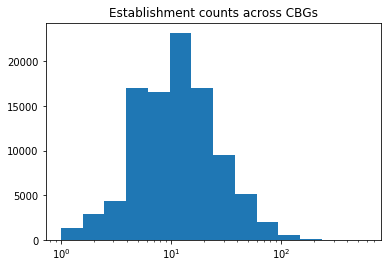

In [10]:
logbins = np.logspace(np.log10(min(data_cbg['est_number']) + 1), 
                      np.log10(max(data_cbg['est_number']) + 1), 
                      15)
plt.hist(data_cbg['est_number'] + 1, bins = logbins)
plt.xscale('log')
plt.title('Establishment counts across CBGs')
plt.show()

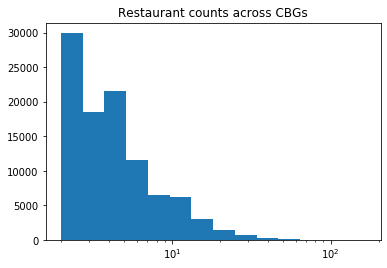

In [11]:
logbins = np.logspace(np.log10(min(data_cbg['rest_number']) + 1), 
                      np.log10(max(data_cbg['rest_number']) + 1), 
                      15)
plt.hist(data_cbg['rest_number'] + 1, bins = logbins)
plt.xscale('log')
plt.title('Restaurant counts across CBGs')
plt.show()

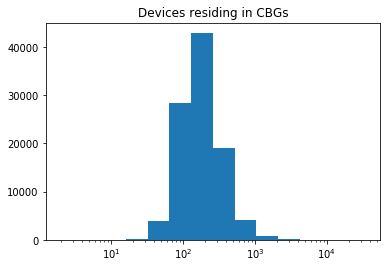

In [12]:
logbins = np.logspace(np.log10(min(data_cbg['number_devices_residing']) + 1), 
                      np.log10(max(data_cbg['number_devices_residing']) + 1), 
                      15)
plt.hist(data_cbg['number_devices_residing'] + 1, bins = logbins)
plt.xscale('log')
plt.title('Devices residing in CBGs')
plt.show()

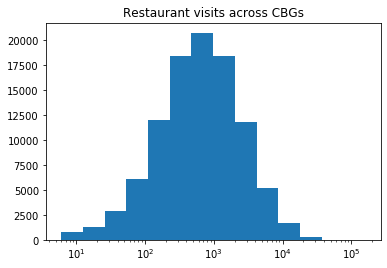

In [13]:
logbins = np.logspace(np.log10(min(data_cbg['rest_visits']) + 1), 
                      np.log10(max(data_cbg['rest_visits']) + 1), 
                      15)
plt.hist(data_cbg['rest_visits'] + 1, bins = logbins)
plt.xscale('log')
plt.title('Restaurant visits across CBGs')
plt.show()

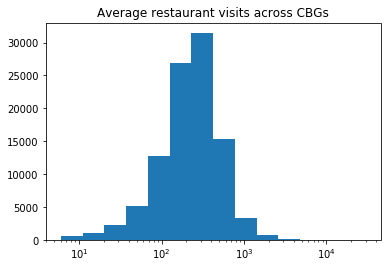

In [14]:
logbins = np.logspace(np.log10(np.nanmin(data_cbg['rest_average_visits']) + 1), 
                      np.log10(np.nanmax(data_cbg['rest_average_visits']) + 1), 
                      15)
plt.hist(data_cbg['rest_average_visits'] + 1, bins = logbins)
plt.xscale('log')
plt.title('Average restaurant visits across CBGs')
plt.show()

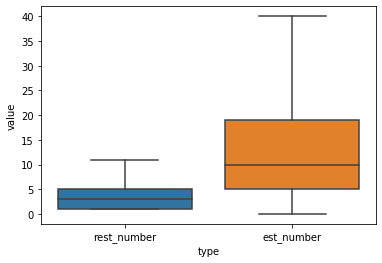

In [15]:
# Restaurant / establishment count distribution comparison
dd = pd.melt(data_cbg, id_vars=['cbg'], value_vars = ['rest_number', 'est_number'], var_name='type')
sns.boxplot(x = 'type', y = 'value', data = dd, showfliers = False)

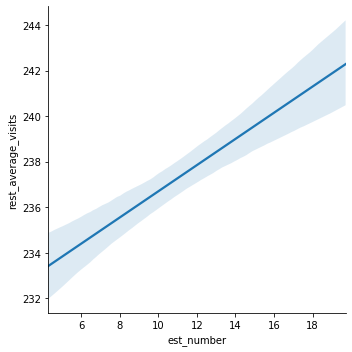

In [16]:
data_subset = ((data_cbg['est_number'] <= data_cbg['est_number'].quantile(0.75)) & 
               (data_cbg['est_number'] >= data_cbg['est_number'].quantile(0.25)) &
               (data_cbg['rest_average_visits'] <= data_cbg['rest_average_visits'].quantile(0.75)) &
               (data_cbg['rest_average_visits'] >= data_cbg['rest_average_visits'].quantile(0.25))
              )
g = sns.lmplot(x = 'est_number', 
               y = 'rest_average_visits',
               data = data_cbg.loc[data_subset],
               scatter = False
              )

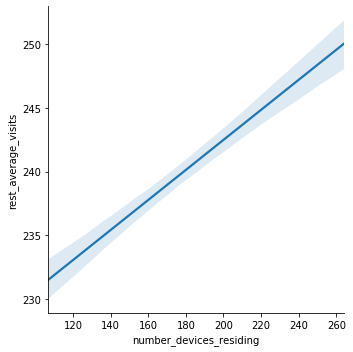

In [17]:
data_subset = ((data_cbg['number_devices_residing'] <= data_cbg['number_devices_residing'].quantile(0.75)) & 
               (data_cbg['number_devices_residing'] >= data_cbg['number_devices_residing'].quantile(0.25)) &
               (data_cbg['rest_average_visits'] <= data_cbg['rest_average_visits'].quantile(0.75)) &
               (data_cbg['rest_average_visits'] >= data_cbg['rest_average_visits'].quantile(0.25))
              )
g = sns.lmplot(x = 'number_devices_residing', 
            y = 'rest_average_visits',
            data = data_cbg.loc[data_subset],
            scatter = False)

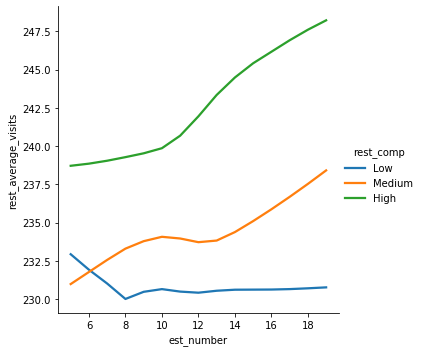

In [18]:
data_subset = ((data_cbg['est_number'] <= data_cbg['est_number'].quantile(0.75)) & 
               (data_cbg['est_number'] >= data_cbg['est_number'].quantile(0.25)) &
               (data_cbg['rest_average_visits'] <= data_cbg['rest_average_visits'].quantile(0.75)) &
               (data_cbg['rest_average_visits'] >= data_cbg['rest_average_visits'].quantile(0.25))
              )
g = sns.lmplot(x = 'est_number', 
               y = 'rest_average_visits',
               hue = 'rest_comp',
               data = data_cbg.loc[data_subset], 
               scatter = False,
               lowess = True)

In [19]:
data_subset = ((data_cbg['rest_comp'] == 'Medium') &
               (data_cbg['est_number'] <= data_cbg['est_number'].quantile(0.75)) & 
               (data_cbg['est_number'] >= data_cbg['est_number'].quantile(0.25)) &
               (data_cbg['rest_average_visits'] <= data_cbg['rest_average_visits'].quantile(0.75)) &
               (data_cbg['rest_average_visits'] >= data_cbg['rest_average_visits'].quantile(0.25))
              )
g = sns.jointplot(x = "est_number", 
                     y = "rest_average_visits", 
                     data = data_cbg.loc[data_subset],
                     kind = 'hex', 
                     space = 0, 
                     color = 'b')

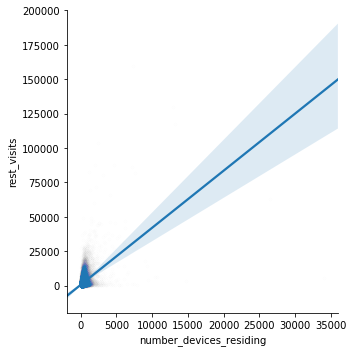

In [20]:
g = sns.lmplot(x = 'number_devices_residing',
               y = 'rest_visits',
               data = data_cbg,
               scatter_kws = {'alpha': 0.002,
                              's': 10})

In [21]:
g = sns.lmplot(x = 'est_number', 
               y = 'rest_visits', 
               data = data_cbg,
               scatter = True,
               scatter_kws = {'alpha': 0.002,
                              's': 10})
g.set(xlim = (0, 50), ylim = (0, 4000))

In [22]:
# Aggregate the data at the census tract level
aggregations = {
    'cbsa': lambda x: x.iloc[0],
    'number_devices_residing': 'sum',
    'rest_number': 'sum',
    'rest_visits': 'sum',
    'est_number': 'sum',
    'est_visits': 'sum'
}

data_ct = data_cbg.groupby('ct',
                           as_index=False).agg(aggregations)

data_ct = data_ct.loc[data_ct['rest_visits'] > 0].copy()

# Average restaurant visits
data_ct['rest_average_visits'] = data_ct.rest_visits / data_ct.rest_number

# Average establishment visits
data_ct['est_average_visits'] = data_ct.est_visits / data_ct.est_number

# Within-CBSA normalization
normalize = lambda df: (df - df.mean()) / df.std()
ct_norm = (data_ct.drop(['ct'], axis = 1)
           .groupby(['cbsa'])
           .transform(normalize)
          )
# Restaurants competition column 
ct_norm['rest_comp'] = pd.qcut(ct_norm['rest_number'],
                               3,
                               labels = ['Low',
                                         'Medium',
                                         'High'])

data_ct['rest_comp'] = pd.qcut(data_ct['rest_number'],
                               3,
                               labels = ['Low',
                                         'Medium',
                                         'High'])

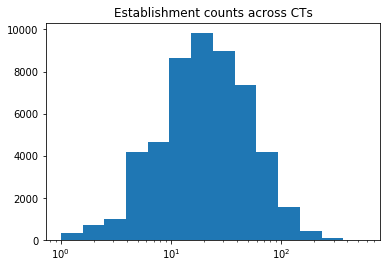

In [23]:
logbins = np.logspace(np.log10(min(data_ct['est_number']) + 1), 
                      np.log10(max(data_ct['est_number']) + 1), 
                      15)
plt.hist(data_ct['est_number'] + 1, bins = logbins)
plt.xscale('log')
plt.title('Establishment counts across CTs')
plt.show()

/home/user/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/user/.local/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


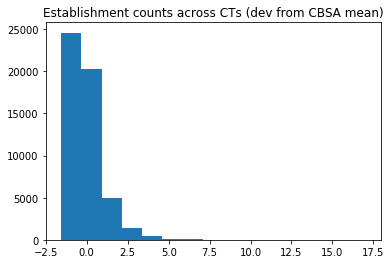

In [24]:
plt.hist(ct_norm['est_number'], bins = 15)
plt.title('Establishment counts across CTs (dev from CBSA mean)')
plt.show()

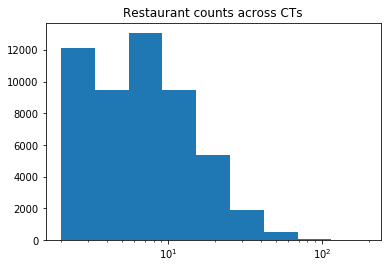

In [25]:
logbins = np.logspace(np.log10(min(data_ct['rest_number']) + 1), 
                      np.log10(max(data_ct['rest_number']) + 1), 
                      10)
plt.hist(data_ct['rest_number'] + 1, bins = logbins)
plt.xscale('log')
plt.title('Restaurant counts across CTs')
plt.show()

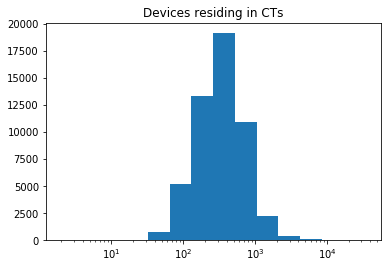

In [26]:
logbins = np.logspace(np.log10(min(data_ct['number_devices_residing']) + 1), 
                      np.log10(max(data_ct['number_devices_residing']) + 1), 
                      15)
plt.hist(data_ct['number_devices_residing'] + 1, bins = logbins)
plt.xscale('log')
plt.title('Devices residing in CTs')
plt.show()

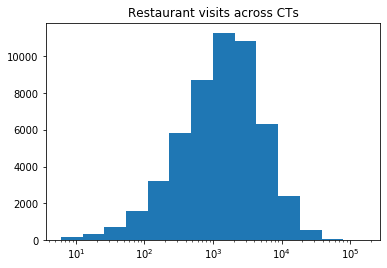

In [27]:
logbins = np.logspace(np.log10(min(data_ct['rest_visits']) + 1), 
                      np.log10(max(data_ct['rest_visits']) + 1), 
                      15)
plt.hist(data_ct['rest_visits'] + 1, bins = logbins)
plt.xscale('log')
plt.title('Restaurant visits across CTs')
plt.show()

In [28]:
logbins = np.logspace(np.log10(np.nanmin(data_ct['rest_average_visits']) + 1), 
                      np.log10(np.nanmax(data_ct['rest_average_visits']) + 1), 
                      15)
plt.hist(data_ct['rest_average_visits'] + 1, bins = logbins)
plt.xscale('log')
plt.title('Average restaurant visits across CTs')
plt.show()

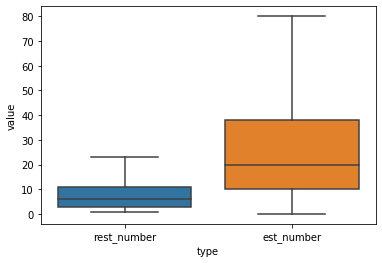

In [29]:
# Restaurant / establishment count distribution comparison
dd = pd.melt(data_ct, id_vars=['ct'], value_vars = ['rest_number', 'est_number'], var_name='type')
sns.boxplot(x = 'type', y = 'value', data = dd, showfliers = False)

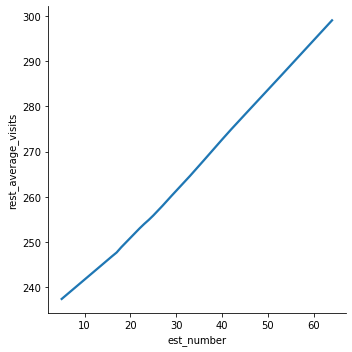

In [30]:
data_subset = ((data_ct['est_number'] <= data_ct['est_number'].quantile(0.9)) & 
               (data_ct['est_number'] >= data_ct['est_number'].quantile(0.1)) &
               (data_ct['rest_average_visits'] <= data_ct['rest_average_visits'].quantile(0.9)) &
               (data_ct['rest_average_visits'] >= data_ct['rest_average_visits'].quantile(0.1))
              )
g = sns.lmplot(x = 'est_number', 
               y = 'rest_average_visits',
               data = data_ct.loc[data_subset],
               scatter = False,
               lowess = True
              )

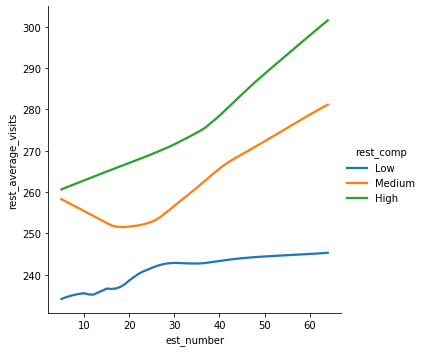

In [31]:
data_subset = ((data_ct['est_number'] <= data_ct['est_number'].quantile(0.9)) & 
               (data_ct['est_number'] >= data_ct['est_number'].quantile(0.1)) &
               (data_ct['rest_average_visits'] <= data_ct['rest_average_visits'].quantile(0.9)) &
               (data_ct['rest_average_visits'] >= data_ct['rest_average_visits'].quantile(0.1))
              )
g = sns.lmplot(x = 'est_number', 
               y = 'rest_average_visits',
               data = data_ct.loc[data_subset],
               scatter = False,
               hue = 'rest_comp',
               lowess = True
              )

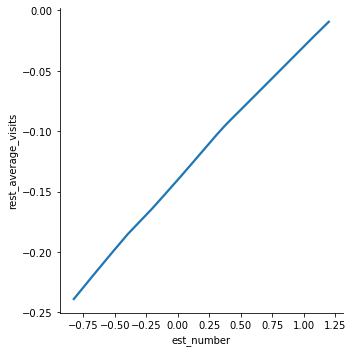

In [32]:
data_subset = ((ct_norm['est_number'] <= ct_norm['est_number'].quantile(0.9)) & 
               (ct_norm['est_number'] >= ct_norm['est_number'].quantile(0.1)) &
               (ct_norm['rest_average_visits'] <= ct_norm['rest_average_visits'].quantile(0.9)) &
               (ct_norm['rest_average_visits'] >= ct_norm['rest_average_visits'].quantile(0.1))
              )
g = sns.lmplot(x = 'est_number', 
               y = 'rest_average_visits',
               data = ct_norm.loc[data_subset],
               lowess = True,
               scatter = False,
               scatter_kws = {'alpha': 0.0095},
              )

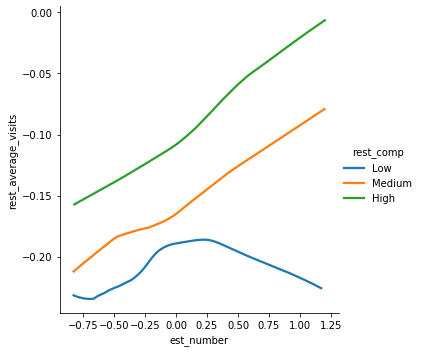

In [33]:
data_subset = ((ct_norm['est_number'] <= ct_norm['est_number'].quantile(0.9)) & 
               (ct_norm['est_number'] >= ct_norm['est_number'].quantile(0.1)) &
               (ct_norm['rest_average_visits'] <= ct_norm['rest_average_visits'].quantile(0.9)) &
               (ct_norm['rest_average_visits'] >= ct_norm['rest_average_visits'].quantile(0.1))
              )
g = sns.lmplot(x = 'est_number', 
               y = 'rest_average_visits',
               hue = 'rest_comp',
               data = ct_norm.loc[data_subset], 
               scatter = False,
               lowess = True)

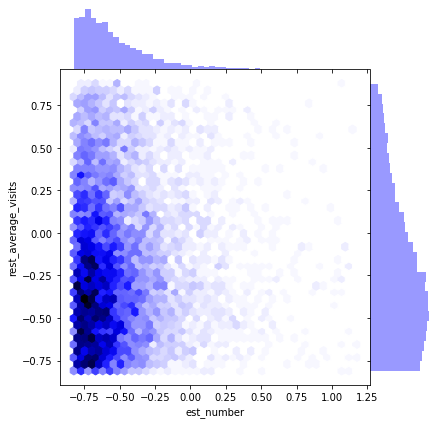

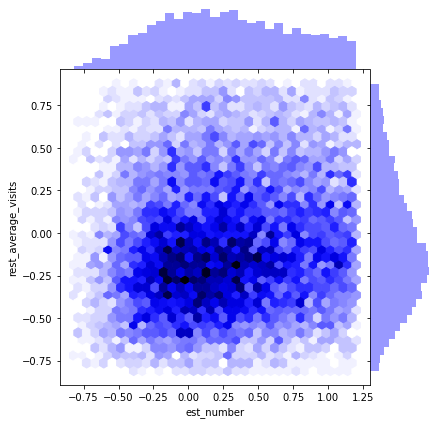

In [34]:
data_subset = ((ct_norm['rest_comp'] == 'Low') &
               (ct_norm['est_number'] <= ct_norm['est_number'].quantile(0.9)) & 
               (ct_norm['est_number'] >= ct_norm['est_number'].quantile(0.1)) &
               (ct_norm['rest_average_visits'] <= ct_norm['rest_average_visits'].quantile(0.9)) &
               (ct_norm['rest_average_visits'] >= ct_norm['rest_average_visits'].quantile(0.1))
              )
g = sns.jointplot(x = "est_number", 
                     y = "rest_average_visits", 
                     data = ct_norm.loc[data_subset],
                     kind = 'hex', 
                     space = 0, 
                     color = 'b')
data_subset = ((ct_norm['rest_comp'] == 'Medium') &
               (ct_norm['est_number'] <= ct_norm['est_number'].quantile(0.9)) & 
               (ct_norm['est_number'] >= ct_norm['est_number'].quantile(0.1)) &
               (ct_norm['rest_average_visits'] <= ct_norm['rest_average_visits'].quantile(0.9)) &
               (ct_norm['rest_average_visits'] >= ct_norm['rest_average_visits'].quantile(0.1))
              )
g = sns.jointplot(x = "est_number", 
                     y = "rest_average_visits", 
                     data = ct_norm.loc[data_subset],
                     kind = 'hex', 
                     space = 0, 
                     color = 'b')
data_subset = ((ct_norm['rest_comp'] == 'High') &
               (ct_norm['est_number'] <= ct_norm['est_number'].quantile(0.9)) & 
               (ct_norm['est_number'] >= ct_norm['est_number'].quantile(0.1)) &
               (ct_norm['rest_average_visits'] <= ct_norm['rest_average_visits'].quantile(0.9)) &
               (ct_norm['rest_average_visits'] >= ct_norm['rest_average_visits'].quantile(0.1))
              )
g = sns.jointplot(x = "est_number", 
                     y = "rest_average_visits", 
                     data = ct_norm.loc[data_subset],
                     kind = 'hex', 
                     space = 0, 
                     color = 'b')

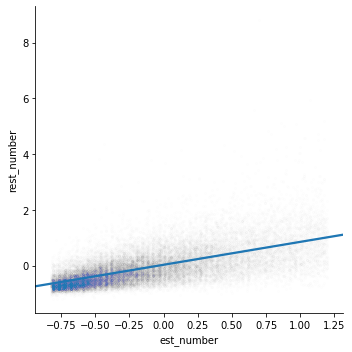

In [35]:
data_subset = ((ct_norm['est_number'] <= ct_norm['est_number'].quantile(0.9)) & 
               (ct_norm['est_number'] >= ct_norm['est_number'].quantile(0.1)) &
               (ct_norm['rest_average_visits'] <= ct_norm['rest_average_visits'].quantile(0.9)) &
               (ct_norm['rest_average_visits'] >= ct_norm['rest_average_visits'].quantile(0.1))
              )
g = sns.lmplot(x = 'est_number', 
               y = 'rest_number',
               data = ct_norm.loc[data_subset],
               scatter = True,
               scatter_kws = {'alpha': 0.002, 's': 5}
              )

In [36]:
data_subset = ((data_ct['est_number'] <= data_ct['est_number'].quantile(0.9)) & 
               (data_ct['est_number'] >= data_ct['est_number'].quantile(0.1)) &
               (data_ct['rest_average_visits'] <= data_ct['rest_average_visits'].quantile(0.9)) &
               (data_ct['rest_average_visits'] >= data_ct['rest_average_visits'].quantile(0.1))
              )
g = sns.lmplot(x = 'number_devices_residing', 
               y = 'rest_average_visits',
               hue = 'rest_comp',
               data = data_ct,
               scatter = False,
               lowess = True)

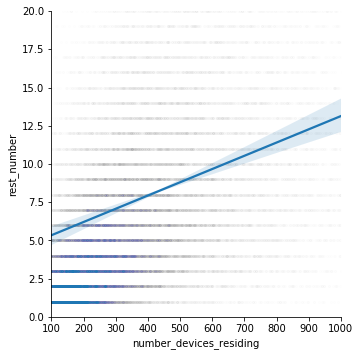

In [37]:
g = sns.lmplot(x = 'number_devices_residing', 
               y = 'rest_number',
               data = data_ct,
               scatter = True,
               scatter_kws = {'alpha': 0.002, 's': 5}
              )
g.set(xlim = (100, 1000), ylim = (0, 20))

In [38]:
# Export data to process on local computer
data_ct.to_csv('/home/user/projects/urban/data/output/proximity/data_ct.csv', index = False)

In [39]:
############################### R integration ##################################

%load_ext rpy2.ipython

################################################################################

In [59]:
# Push the Census Tracts dataset to R
%Rpush data_ct

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



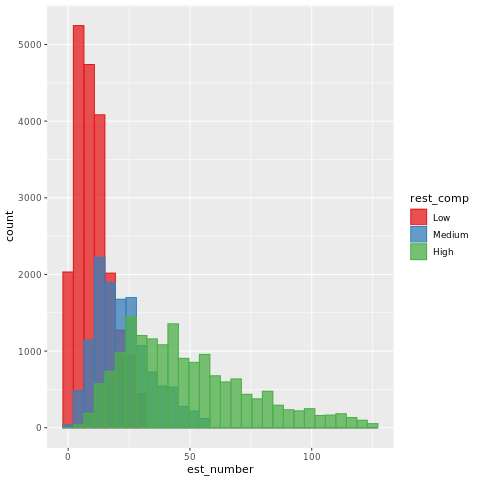

In [60]:
%%R
library(ggplot2)
library(dplyr)
# Function to remove outliers
remove_outliers <- function(x, na.rm = TRUE, ...) {
    qnt <- quantile(x, probs=c(.25, .75), na.rm = na.rm, ...)
    H <- 1.5 * IQR(x, na.rm = na.rm)
    y <- x
    y[x < (qnt[1] - H)] <- NA
    y[x > (qnt[2] + H)] <- NA
    y
}
# Remove outliers
data_ct <- data_ct %>% 
    group_by(rest_comp) %>% 
    mutate_at(vars(est_number, rest_average_visits), 
              funs(remove_outliers))
# Plot within-group distribution of establishments count
ggplot(data = data_ct, 
       aes(x = est_number, 
           color = rest_comp, fill = rest_comp)) + 
    geom_histogram(position = 'identity', alpha = 0.75) + 
    scale_color_brewer(palette = 'Set1') + 
    scale_fill_brewer(palette = 'Set1')

#data_subset <- data_ct %>% 
#filter((est_number < quantile(est_number, 0.9)) & 
#       (est_number > quantile(est_number, 0.1)) & 
#       (rest_average_visits < quantile(rest_average_visits, 0.9)) &
#       (rest_average_visits > quantile(rest_average_visits, 0.1)))
#ggplot(data = data_subset, 
#       aes(x = est_number, 
#           y = rest_average_visits, 
#           color = rest_comp)) + geom_smooth()
#ggplot(data = data_subset, 
#       aes(x = est_number, 
#           y = rest_average_visits, 
#           color = rest_comp)) + geom_smooth(method = 'loess')

R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



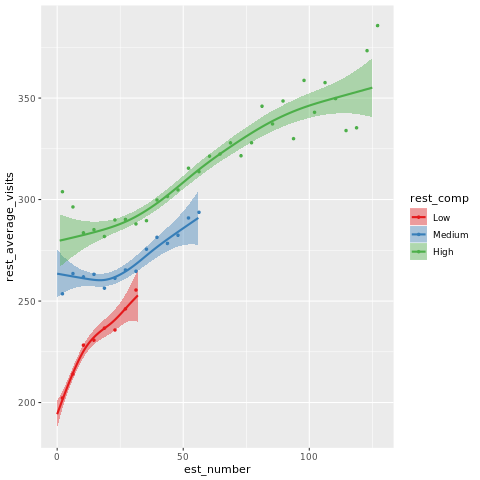

In [62]:
%%R
ggplot(data = data_ct, 
       aes(x = est_number, 
           y = rest_average_visits, 
           color = rest_comp, 
           fill = rest_comp)) + 
    geom_smooth() + 
    stat_summary_bin(fun.y = 'mean', bins = 30, size = 1, geom = 'point') +
    scale_color_brewer(palette = 'Set1') + 
    scale_fill_brewer(palette = 'Set1')

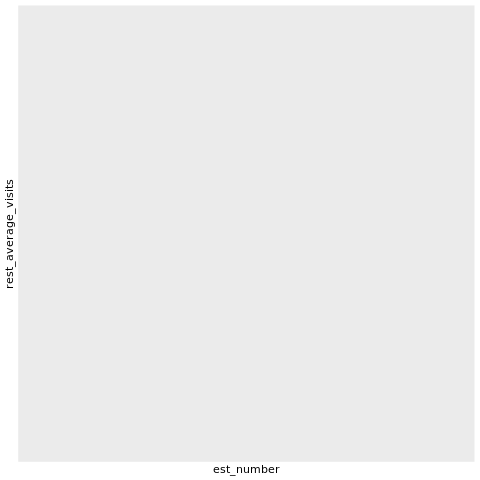

In [43]:
%%R
ggplot(data = data_ct, 
       aes(x = est_number, 
           y = rest_average_visits, color = rest_comp)) + 
    geom_smooth(method = 'loess') + 
    scale_color_brewer(palette = 'Set1') + 
    scale_fill_brewer(palette = 'Set1')

In [1]:
%%R
library(scales)
library(tidyr)
quantiles <- quantile(data_ct$est_number, probs = seq(0, 1, 0.05))
data_ct$est_number_quantile <- cut(data_ct$est_number, 
                                   breaks = quantiles, 
                                   labels = names(quantiles)[2:length(quantiles)], 
                                   include.lowest = TRUE)
data_categorized <- data_ct %>% 
mutate(ind = 1) %>% 
pivot_wider(names_from = rest_comp,
            values_from = ind, 
            values_fill = list(ind = 0)
           ) %>%
group_by(est_number_quantile) %>% 
summarise(Low = sum(Low) / n(), 
          Medium = sum(Medium) / n(),
          High = sum(High) / n()
         ) %>%
pivot_longer(cols = -est_number_quantile, 
             values_to = 'share')
data_categorized$name <- factor(data_categorized$name, 
                                levels = c('High', 'Medium', 'Low'), 
                                ordered = TRUE)
ggplot(data_categorized, aes(x = est_number_quantile, 
                             y = share, 
                             fill = name)) + 
    geom_bar(position = "fill",
             stat = "identity") +
    scale_y_continuous(labels = scales::percent_format())

UsageError: Cell magic `%%R` not found.


In [63]:
# Push the Census Tracts dataset to R
%Rpush data_ct

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



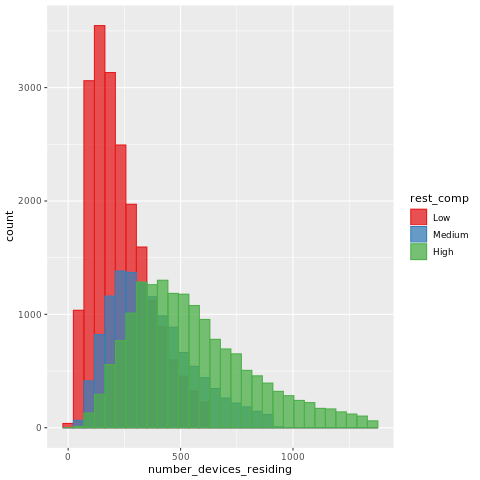

In [64]:
%%R
# SAME WITH DEVICES RESIDING
# REMEBER TO RELOAD THE DATA FIRST
data_ct <- data_ct %>%
    group_by(rest_comp) %>%
    mutate_at(vars(number_devices_residing, rest_average_visits),
    funs(remove_outliers))

ggplot(data = data_ct, 
       aes(x = number_devices_residing, 
           color = rest_comp, fill = rest_comp)) + 
    geom_histogram(position = 'identity', alpha = 0.75) + 
    scale_color_brewer(palette = 'Set1') + 
    scale_fill_brewer(palette = 'Set1')

R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



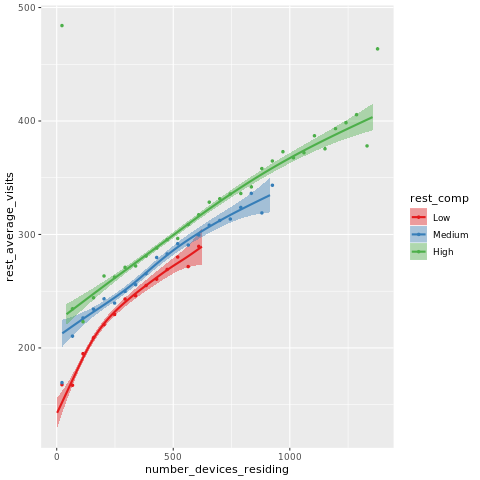

In [65]:
%%R
ggplot(data = data_ct, 
       aes(x = number_devices_residing, 
           y = rest_average_visits, 
           color = rest_comp, 
           fill = rest_comp)) +
geom_smooth() + 
stat_summary_bin(fun.y = 'mean', bins = 30, size = 1, geom = 'point') +
scale_color_brewer(palette = 'Set1') + 
scale_fill_brewer(palette = 'Set1')

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



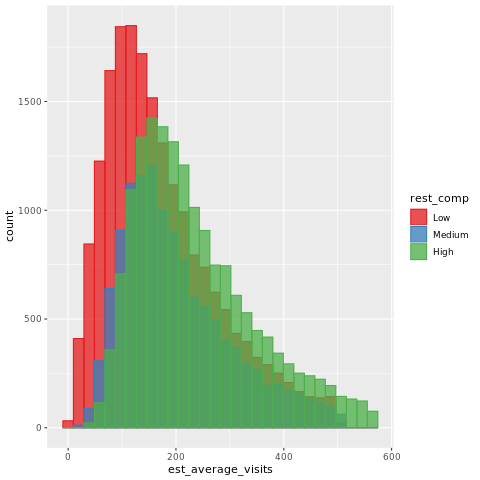

In [45]:
%%R
# Establishment visits
library(ggplot2)
library(dplyr)
# Function to remove outliers
remove_outliers <- function(x, na.rm = TRUE, ...) {
    qnt <- quantile(x, probs=c(.25, .75), na.rm = na.rm, ...)
    H <- 1.5 * IQR(x, na.rm = na.rm)
    y <- x
    y[x < (qnt[1] - H)] <- NA
    y[x > (qnt[2] + H)] <- NA
    y
}
# Remove outliers
data_ct <- data_ct %>% 
    group_by(rest_comp) %>% 
    mutate_at(vars(est_average_visits, rest_average_visits), 
              funs(remove_outliers))
# Plot within-group distribution of establishments count
ggplot(data = data_ct, 
       aes(x = est_average_visits, 
           color = rest_comp, fill = rest_comp)) + 
    geom_histogram(position = 'identity', alpha = 0.75) + 
    scale_color_brewer(palette = 'Set1') + 
    scale_fill_brewer(palette = 'Set1')

R[write to console]: `geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



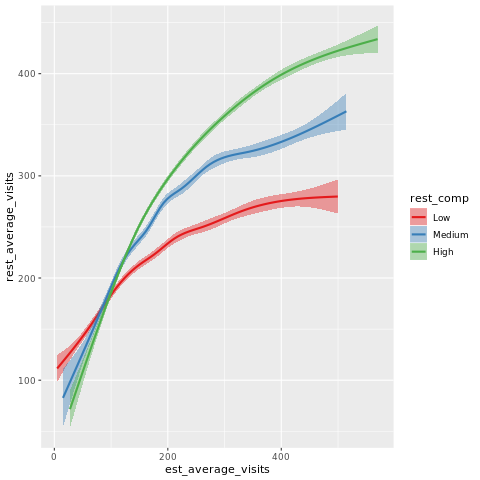

In [46]:
%%R
ggplot(data = data_ct, 
       aes(x = est_average_visits, 
           y = rest_average_visits, 
           color = rest_comp, 
           fill = rest_comp)) + 
    geom_smooth() + 
    scale_color_brewer(palette = 'Set1') + 
    scale_fill_brewer(palette = 'Set1')